In [1]:
import os
os.chdir(os.getcwd().replace('/Code', ''))

In [2]:
import functions
import pandas as pd
import gzip
import pickle as pkl
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import seaborn as sns
from sklearn import decomposition, preprocessing
import seaborn as sns
from sklearn.manifold import TSNE

# Récupération de la matrice précédente avec les CV en liste de tokens

In [3]:
with gzip.open('Matrices/CVs3_tokenization.pkl.gz', 'rb') as f:
        CVs = pkl.load(f)
print(CVs.shape)

(8205, 4)


# Matrice d'occurrences

In [4]:
joincv = [" ".join(CVs.loc[cv]['cv_list']) for cv in CVs.index]
vectorizer = CountVectorizer(token_pattern="[\S]+")
X = vectorizer.fit_transform(joincv)
DataFrame_Count = pd.DataFrame(X.toarray(),  columns=vectorizer.get_feature_names(), index=CVs.index)
print("Le vocabulaire de base contient", DataFrame_Count.shape[1], "tokens pour", DataFrame_Count.shape[0], 'cv.')

Le vocabulaire de base contient 91920 tokens pour 8205 cv.


# Etude sur l'apparition des mots

In [5]:
df_stat = pd.DataFrame(index =DataFrame_Count.columns)
df_stat['mot'] = DataFrame_Count.columns
df_stat['nb_occ_tot'] = list(DataFrame_Count.sum(axis=0))
df_stat['pct_occ_tot'] = df_stat['nb_occ_tot'] / DataFrame_Count.shape[1] *100
df_stat['nb_CV'] = list(DataFrame_Count.astype(bool).sum(axis=0))
df_stat['pct_CV'] = df_stat['nb_CV'] / DataFrame_Count.shape[0] *100
df_stat['nb_occ_moyen_par_CV'] = df_stat['nb_occ_tot'] / df_stat['nb_CV']
print(df_stat.describe())

         nb_occ_tot   pct_occ_tot         nb_CV        pct_CV  \
count  91920.000000  91920.000000  91920.000000  91920.000000   
mean      44.294332      0.048188     22.865611      0.278679   
std      551.987958      0.600509    173.403180      2.113384   
min        1.000000      0.001088      1.000000      0.012188   
25%        1.000000      0.001088      1.000000      0.012188   
50%        2.000000      0.002176      1.000000      0.012188   
75%        5.000000      0.005440      3.000000      0.036563   
max    56819.000000     61.813534   7326.000000     89.287020   

       nb_occ_moyen_par_CV  
count         91920.000000  
mean              1.304454  
std               0.859301  
min               1.000000  
25%               1.000000  
50%               1.000000  
75%               1.329353  
max              46.000000  


In [6]:
df_stat.loc[df_stat['nb_CV']<4].shape[0]/df_stat.shape[0]

0.756429503916449

### Suppression des mots peu fréquents 

In [7]:
df_stat.quantile([0.1,0.5,0.6,0.7,0.8,0.85,0.9,0.95,1])

,nb_occ_tot,pct_occ_tot,nb_CV,pct_CV,nb_occ_moyen_par_CV
0.10,1.0,0.001088,1.0,0.012188,1.000000
0.50,2.0,0.002176,1.0,0.012188,1.000000
0.60,2.0,0.002176,2.0,0.024375,1.000000
0.70,3.0,0.003264,3.0,0.036563,1.166667
0.80,7.0,0.007615,5.0,0.060938,1.500000
0.85,11.0,0.011967,8.0,0.097502,1.744260
0.90,22.0,0.023934,16.0,0.195003,2.000000
0.95,71.0,0.077241,50.0,0.609385,2.250000
1.00,56819.0,61.813534,7326.0,89.287020,46.000000


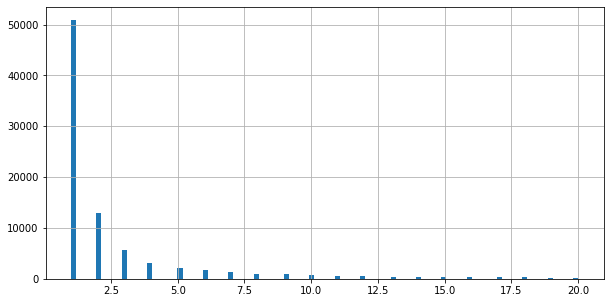

In [12]:
plt.figure(figsize=(10, 5))
df_stat['nb_CV'].loc[df_stat['nb_CV']<=20].hist(bins=100)
plt.show()

Généralement on a un mot par cv (nom d'entreprise apparait une fois). Donc on conservera seulement les mots qui apparaissent dans au moins 4 CV.

In [13]:
liste_mots_a_supprimer_peu_freq = list(df_stat.loc[df_stat['nb_CV']<4].index)
print('On va supprimer',len(liste_mots_a_supprimer_peu_freq), 'mots. Il restera',df_stat.shape[0] - len(liste_mots_a_supprimer_peu_freq) ,'mots dans le vocabulaire.')

On va supprimer 69531 mots. Il restera 22389 mots dans le vocabulaire.


### Suppression des mots trops fréquents

In [14]:
df_stat.sort_values(by='pct_CV', ascending=False)[0:40]

,mot,nb_occ_tot,pct_occ_tot,nb_CV,pct_CV,nb_occ_moyen_par_CV
experience,experience,12089,13.151654,7326,89.287020,1.650150
management,management,56819,61.813534,6967,84.911639,8.155447
project,project,56004,60.926893,6790,82.754418,8.248012
training,training,16597,18.055918,6546,79.780622,2.535441
development,development,46421,50.501523,6440,78.488726,7.208230
language,language,13531,14.720409,6029,73.479586,2.244319
english,english,7820,8.507398,5915,72.090189,1.322063
professional,professional,9211,10.020670,5788,70.542352,1.591396
application,application,31709,34.496301,5700,69.469835,5.562982
technical,technical,33225,36.145561,5499,67.020110,6.042008


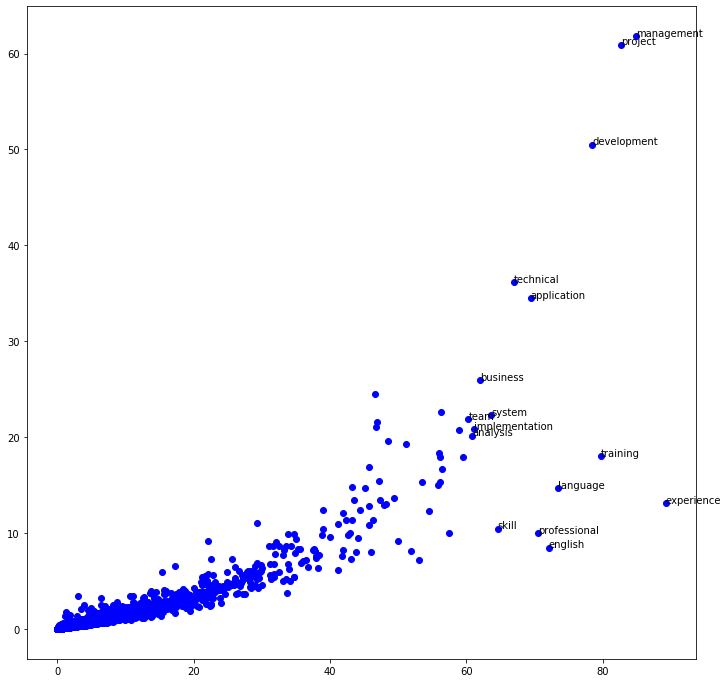

In [15]:
plt.figure(figsize=(12, 12))
plt.plot(df_stat['pct_CV'], df_stat['pct_occ_tot'], 'bo')
for i in range(len(df_stat['pct_CV'])):
    if df_stat['pct_CV'][i]>=60:
        plt.annotate(df_stat['mot'][i], xy=(df_stat['pct_CV'][i],df_stat['pct_occ_tot'][i]))
plt.show()

### suppression des mots qui apparaissent dans plus de 60% des CV

In [16]:
liste_mots_a_supprimer_trop_freq = list(df_stat.loc[df_stat['pct_CV']>=60].index)
print('On va supprimer en plus',len(liste_mots_a_supprimer_trop_freq), 'mots')

On va supprimer en plus 16 mots


In [17]:
liste_mots_a_supprimer = liste_mots_a_supprimer_trop_freq + liste_mots_a_supprimer_peu_freq
print(len(liste_mots_a_supprimer))
print('On va supprimer',len(liste_mots_a_supprimer), 'mots. Il restera',df_stat.shape[0] - len(liste_mots_a_supprimer) ,'mots dans le vocabulaire.')

69547
On va supprimer 69547 mots. Il restera 22373 mots dans le vocabulaire.


# Nouvelle matrice d'occurrences

In [18]:
joincv = [" ".join(CVs.loc[cv]['cv_list']) for cv in CVs.index]
vectorizer = CountVectorizer(token_pattern="[\S]+", min_df=4, max_df=0.6)
X = vectorizer.fit_transform(joincv)
DataFrame_Count = pd.DataFrame(X.toarray(),  columns=vectorizer.get_feature_names(), index=CVs.index)
print("Le vocabulaire de base contient", DataFrame_Count.shape[1], "tokens pour", DataFrame_Count.shape[0], 'cv.')

Le vocabulaire de base contient 22373 tokens pour 8205 cv.


# Matrice TFIDF

In [19]:
vectorizer = TfidfVectorizer(token_pattern="[\S]+",  min_df=4, max_df=0.6)
X = vectorizer.fit_transform(joincv)
DataFrame_TFIDF = pd.DataFrame(X.toarray(),  columns=vectorizer.get_feature_names(), index=CVs.index)
print(DataFrame_TFIDF.shape)

(8205, 22373)


# ACP

In [20]:
from sklearn import decomposition, preprocessing
pca = decomposition.PCA(n_components = 2, random_state=123)
X_projected = pca.fit_transform(DataFrame_TFIDF)

Text(0, 0.5, 'axe 1')

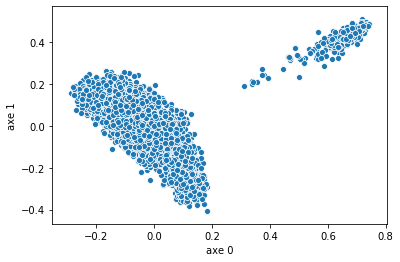

In [21]:
import seaborn as sns
sns.scatterplot(x=X_projected[:, 0], y=X_projected[:, 1])
plt.xlabel("axe 0")
plt.ylabel("axe 1")

248


Text(0, 0.5, 'axe 1')

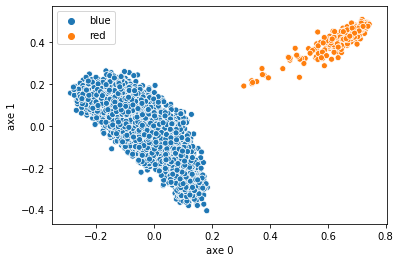

In [22]:
xmin = 0.2
xmax = 1
ymin = 0
ymax = 1
i = [j for j in range(len(X_projected)) if ymin<= X_projected[j,1]<=ymax and xmin<= X_projected[j,0]<=xmax]
id = list(CVs.index[i])
print(len(id))
clusters =  ['red' if ymin<= X_projected[j,1]<=ymax and xmin<= X_projected[j,0]<=xmax else 'blue' for j in range(len(X_projected)) ]
sns.scatterplot(x=X_projected[:, 0], y=X_projected[:, 1], hue=clusters)
plt.xlabel("axe 0")
plt.ylabel("axe 1")

In [23]:
sub_df_class = DataFrame_Count.loc[id]
print(sub_df_class.astype(bool).sum(axis=0).sort_values(ascending=False)[40:80])

contract         241
list             241
phone            241
native           241
geographic       239
specify          239
area             239
certain          238
french           238
freelance        238
notice           237
end              237
address          236
csd              235
period           235
alternation      234
residence        234
function         234
traineeship      232
country          230
occasional       228
bargain          228
tel              224
limited          224
city             221
trip             216
order            214
chronological    214
credential       213
enter            213
graduation       213
company          213
mrs              205
miss             171
france           161
manager          159
code             141
place            135
zip              130
society          120
dtype: int64


In [24]:
df_stat = pd.DataFrame(index =sub_df_class.columns)
df_stat['mot'] = sub_df_class.columns
df_stat['nb_CV'] = list(sub_df_class.astype(bool).sum(axis=0))
stop_words = list(df_stat.loc[df_stat['nb_CV']>=160].index)
stop_words.remove('security')
stop_words.extend(['birthplace','place', 'postcode',"mother","email",'ms',
                  'language', 'application', 'society', 'zip', 'telephone', 'position', 'luxembourg', 
                   'code', 'average', 'linkedin', 'www', 'page', 'de',])
import calendar
month = [calendar.month_name[i].lower() for i in range(1,13)]
stop_words.extend(month)
print(stop_words)
print(len(stop_words))

['address', 'alternation', 'area', 'availability', 'available', 'bargain', 'beginner', 'birth', 'cdi', 'certain', 'chronological', 'city', 'company', 'contact', 'contract', 'country', 'credential', 'csd', 'current', 'date', 'desire', 'diploma', 'end', 'enter', 'fax', 'fluent', 'form', 'france', 'freelance', 'french', 'function', 'geographic', 'graduation', 'immediately', 'indicate', 'information', 'intermediate', 'job', 'level', 'limited', 'list', 'mail', 'miss', 'mobile', 'mobility', 'mr', 'mrs', 'nationality', 'native', 'notice', 'number', 'occasional', 'order', 'period', 'personal', 'phone', 'qualification', 'recent', 'reference', 'residence', 'rub', 'salary', 'seek', 'social', 'speak', 'specify', 'tel', 'thank', 'total', 'traineeship', 'trip', 'type', 'year', 'you', 'birthplace', 'place', 'postcode', 'mother', 'email', 'ms', 'language', 'application', 'society', 'zip', 'telephone', 'position', 'luxembourg', 'code', 'average', 'linkedin', 'www', 'page', 'de', 'january', 'february', 

### représentation des CV sans les stops précédents

In [25]:
joincv = [" ".join(CVs.loc[cv]['cv_list']) for cv in CVs.index]
vectorizer = CountVectorizer(token_pattern="[\S]+", min_df=4,max_df=0.6, stop_words=stop_words)
X = vectorizer.fit_transform(joincv)
DataFrame_Count = pd.DataFrame(X.toarray(),  columns=vectorizer.get_feature_names(), index=CVs.index)
print("Le vocabulaire de base contient", DataFrame_Count.shape[1], "tokens pour", DataFrame_Count.shape[0], 'cv.')

Le vocabulaire de base contient 22270 tokens pour 8205 cv.


In [26]:
vectorizer = TfidfVectorizer(token_pattern="[\S]+",min_df=4,max_df=0.6, stop_words=stop_words)
X = vectorizer.fit_transform(joincv)
DataFrame_TFIDF = pd.DataFrame(X.toarray(),  columns=vectorizer.get_feature_names(), index=CVs.index)
print(DataFrame_TFIDF.shape)

(8205, 22270)


In [27]:
pca = decomposition.PCA(n_components = 2, random_state=123)
X_projected = pca.fit_transform(DataFrame_TFIDF)

Text(0, 0.5, 'axe 1')

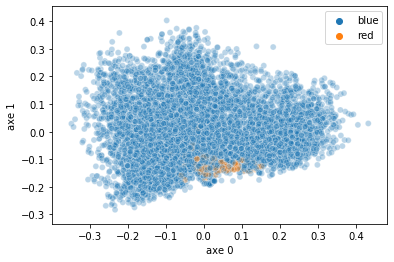

In [28]:
sns.scatterplot(x=X_projected[:, 0], y=X_projected[:, 1], hue=clusters, alpha=0.3)
plt.xlabel("axe 0")
plt.ylabel("axe 1")

In [29]:
#stop words
SW = liste_mots_a_supprimer.copy()
SW.extend(stop_words)
print(len(SW))

#mots du vocabulaire
vocab = list(DataFrame_Count.columns)
print(len(vocab))

69652
22270


In [30]:
with gzip.open('Matrices/stop_words4a.pkl.gz', 'wb') as f:
    pkl.dump(SW, f)

In [31]:
with gzip.open('Matrices/vocabulaire4a.pkl.gz', 'wb') as f:
    pkl.dump(vocab, f)

## Suppression dans les listes

In [32]:
liste_CV_id = [[CVs.loc[cv]['cv_list'], CVs.loc[cv]['id_CV']] for cv in CVs.index ]
print(len(liste_CV_id))

8205


In [33]:
from multiprocessing import Pool
from functools import reduce
def etape_map(CV_and_id):
    CV_list = CV_and_id[0]
    id_CV = CV_and_id[1]
    
    vocab_cv_list = [mot for mot in CV_list if mot in vocab]
  
    return ([id_CV], [vocab_cv_list])

def etape_reduce(a, b):
    a[0].append(b[0][0])
    a[1].append(b[1][0])
    return a

In [34]:
%%time
with Pool() as pool:
    m = pool.map(etape_map, liste_CV_id)
    
r = reduce(etape_reduce, m)

CPU times: user 3.3 s, sys: 1.06 s, total: 4.35 s
Wall time: 13min 45s


In [41]:
rdf = pd.DataFrame(r).transpose()
rdf.columns=['id_CV', "vocab_cv_list"]
rdf.index = rdf['id_CV']
rdf = rdf.drop('id_CV', axis=1)
CVs_vocab = CVs.join(rdf)

In [42]:
CVs_vocab.head(5)

,id_CV,cv_list,len_cv_initial,traduction,vocab_cv_list
id_CV,,,,,
5711,5711,"[jaouadi, junior, data, scientist, jaouadi, ju...",4477,Jaouadi - Junior Data Scientist\n\n\n Jaouadi...,"[junior, data, scientist, junior, data, scient..."
669,669,"[breton, consultant, moa, business, analysis, ...",6699,Breton\n\n\n \n75\n\n . . . . .\n Consult...,"[breton, consultant, moa, finance, confirm, do..."
938,938,"[read, write, talk, read, write, talk, read, s...",5769,94. : +33 0 1 45 18 33: 33 ....\n \n\n \...,"[read, write, talk, read, write, talk, read, c..."
1835,1835,"[mr, nationality, french, date, birth, mail, p...",2353,M\n\nMr. Nationality: French\nDate of birth: 1...,"[java, j2ee, education, oracle, performance, t..."
266,266,"[de, reguardati, financial, engineer, de, regu...",4407,de'Reguardati - Financial Engineer\n\n\n de'R...,"[financial, engineer, financial, engineer, fin..."


In [43]:
CVs_vocab = CVs_vocab.drop(["id_CV", 'traduction'], axis=1)
CVs_vocab.head()

,cv_list,len_cv_initial,vocab_cv_list
id_CV,,,
5711,"[jaouadi, junior, data, scientist, jaouadi, ju...",4477,"[junior, data, scientist, junior, data, scient..."
669,"[breton, consultant, moa, business, analysis, ...",6699,"[breton, consultant, moa, finance, confirm, do..."
938,"[read, write, talk, read, write, talk, read, s...",5769,"[read, write, talk, read, write, talk, read, c..."
1835,"[mr, nationality, french, date, birth, mail, p...",2353,"[java, j2ee, education, oracle, performance, t..."
266,"[de, reguardati, financial, engineer, de, regu...",4407,"[financial, engineer, financial, engineer, fin..."


In [44]:
with gzip.open('Matrices/CVs4a_vocabulaire.pkl.gz', 'wb') as f:
    pkl.dump(CVs_vocab, f)